# Introduction

Estimating the price of a used car in the real world is not as straightforward as it may seem. Vehicle listings are often messy, inconsistent, and incomplete, yet accurate pricing plays a key role in decision making for both buyers and sellers. In this work, we focused on building a practical and reliable machine learning solution that can estimate car prices from real world data rather than ideal or perfectly curated datasets. Our goal was to design a model that performs well on unseen data while remaining simple enough to understand, evaluate, and extend.

We implemented the entire workflow in a single notebook, covering data cleaning, feature engineering, preprocessing, model training, hyperparameter tuning, and evaluation. A significant part of the effort went into handling categorical features and missing values in a way that reflects how this data appears in practice. To improve model stability and predictive performance, we applied log transformation to the target variable, scaled numerical features, and used target encoding for categorical columns. Multiple regression models were trained and compared, ranging from simple linear models to more advanced tree-based ensemble approaches. Model selection was guided by several evaluation metrics, including MAE, RMSE, $R^2$, Median Absolute Error, and MAPE, along with a composite score designed to balance accuracy and generalization.

The results show that ensemble-based models are more effective at capturing the complex and non-linear relationships present in vehicle pricing data. The final selected model demonstrates strong predictive performance with a low generalization gap between training and test results.

To enable real-time testing of the trained model, a live prediction interface has been deployed and is publicly accessible at:
**[https://cars4you.onrender.com/](https://cars4you.onrender.com/)**

<img src="cars4you-app-ss.png" alt="App Interface Screenshot" width="800"/>

*Figure 1: The live prediction interface allowing users to estimate vehicle prices in real-time.*

This deployment completes the end-to-end pipeline, demonstrating how the proposed approach can be applied in a real-world setting beyond offline experimentation.

# Imports

In [1]:
!pip install -q tabulate
!pip install category_encoders

import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import category_encoders as ce

from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import (
    BaggingRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor
)
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    median_absolute_error
)
import joblib

# Exploratory Data Analysis (EDA)

## Data Quality and Consistency Check

To ensure the dataset is reliable for analysis, we check for:
- Check for Duplicates
- Features(Numeric and Categorical)
- Inconsistency in data
- Correlations among numerical features
- Overall feature consistency and anomalies

In [2]:
cars = pd.read_csv("project_data/train.csv")
print("Data shape:", cars.shape)
cars.info()
cars.head()

Data shape: (75973, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


## Removing Duplicates

In [3]:
cars.set_index('carID', inplace=True)
cars = cars.drop_duplicates().reset_index()

## Statistical Analysis of the data

In [4]:
cars.drop(columns=['carID']).describe()

,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
count,74478.000000,75969.000000,74507.000000,68067.000000,68045.000000,74453.000000,74445.000000,74419.000000,74421.0
mean,2017.096576,16882.001922,23004.761128,120.328500,55.152286,1.660161,64.591773,1.994485,0.0
std,2.208750,9737.075658,22130.041696,65.522046,16.497834,0.573464,21.020975,1.472961,0.0
min,1970.000000,450.000000,-58540.574478,-91.121630,-43.421768,-0.103493,1.638913,-2.345650,0.0
25%,2016.000000,10200.000000,7423.500000,125.000000,46.300000,1.200000,47.000000,1.000000,0.0
50%,2017.000000,14699.000000,17301.000000,145.000000,54.300000,1.600000,65.000000,2.000000,0.0
75%,2019.000000,20950.000000,32428.000000,145.000000,62.800000,2.000000,82.000000,3.000000,0.0
max,2024.121759,159999.000000,323000.000000,580.000000,470.800000,6.600000,125.594308,6.258371,0.0


### Separate Numerical and Categorical Features

We separate the columns into two lists: numerical and categorical. This distinction is necessary because different preprocessing techniques will be applied to each type (e.g., scaling for numerical, encoding for categorical).

* **Numerical:** Derived by selecting number data types. Note that we explicitly drop `carID` as it is an index identifier and has no predictive power for car prices.
* **Categorical:** Derived by selecting all non-numeric data types (object/string).

In [5]:
num_cols = cars.select_dtypes(include=[np.number]).drop(columns=['carID']).columns.tolist()
cat_cols = cars.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

Numeric columns: ['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'hasDamage']
Categorical columns: ['Brand', 'model', 'transmission', 'fuelType']


## Data Inconsistency Check
- Impossible Year Check(Since data is till 2020, year with 2024 should not exist)
- Checking of Zero's(0's) in data, Since previousOwners, hasDamage(Boolean) & Tax can be zero, A consistency check is mandatory on rest
- Missing Values in Numerical & Categorical Columns along with Percentage of data which is missing

## Data Inconsistency & Missing Value Analysis

We perform a series of checks to ensure data integrity before preprocessing:

1.  **Future Year:** We identify cars listed with a registration year > 2020 (future dates), which are treated as errors.
2.  **Numerical Anomalies (Negative Values):** We scan all numerical columns for negative values. While zeros are calculated, we specifically flag columns containing negative numbers as these are likely data entry errors (e.g., negative mileage or tax).
3.  **Categorical/Numerical Missing Values:**
    * **Dirty Data Check:** We detect non-standard missing values disguised as strings (e.g., "nan", "none", "null", or empty strings).
    * **Standard Missing Check:** We calculate the percentage of `NaN` values per feature.

### Impossible Year Check

In [6]:
impossible_years = cars[cars['year'] > 2020]
print(f"Number of cars with year > 2020: {len(impossible_years)}")

Number of cars with year > 2020: 358


### Check for Zero values in Numerical Columns

In [7]:
num_cols = cars.select_dtypes(include=[np.number]).columns.tolist()
valid_zero_cols = ['previousOwners', 'hasDamage', 'tax']
invalid_summary = []

for col in num_cols:
    zero_count = (cars[col] == 0).sum()
    neg_count = (cars[col] < 0).sum()
    perc_zero = (cars[col] == 0).mean() * 100
    perc_neg = (cars[col] < 0).mean() * 100

    if zero_count > 0 or neg_count > 0:
        invalid_summary.append((col, zero_count, neg_count, perc_zero, perc_neg))

if invalid_summary:
    invalid_df = pd.DataFrame(
        invalid_summary,
        columns=["Column", "Zero Count", "Negative Count", "% Zero", "% Negative"]
    )

    print("Columns with Negative Values:\n")
    display(invalid_df[invalid_df["Negative Count"] > 0])
else:
    print("No zero or negative values found in numeric columns.")

Columns with Negative Values:



,Column,Zero Count,Negative Count,% Zero,% Negative
1,mileage,0,369,0.000000,0.485724
2,tax,4320,378,5.686530,0.497571
3,mpg,0,36,0.000000,0.047388
4,engineSize,180,84,0.236939,0.110571
5,previousOwners,14879,371,19.585620,0.488357


### Missing Values check

Missing Values in Categorical Columns:



,Missing Count
transmission,1522
Brand,1521
model,1517
fuelType,1511


Missing Values in Categorical Columns:



,Missing Count,Missing %
transmission,1522,2.003449
Brand,1521,2.002132
model,1517,1.996867
fuelType,1511,1.988969


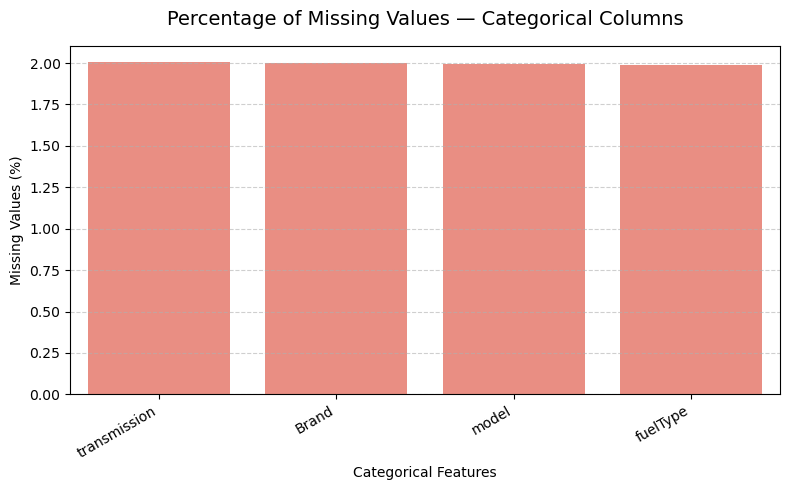

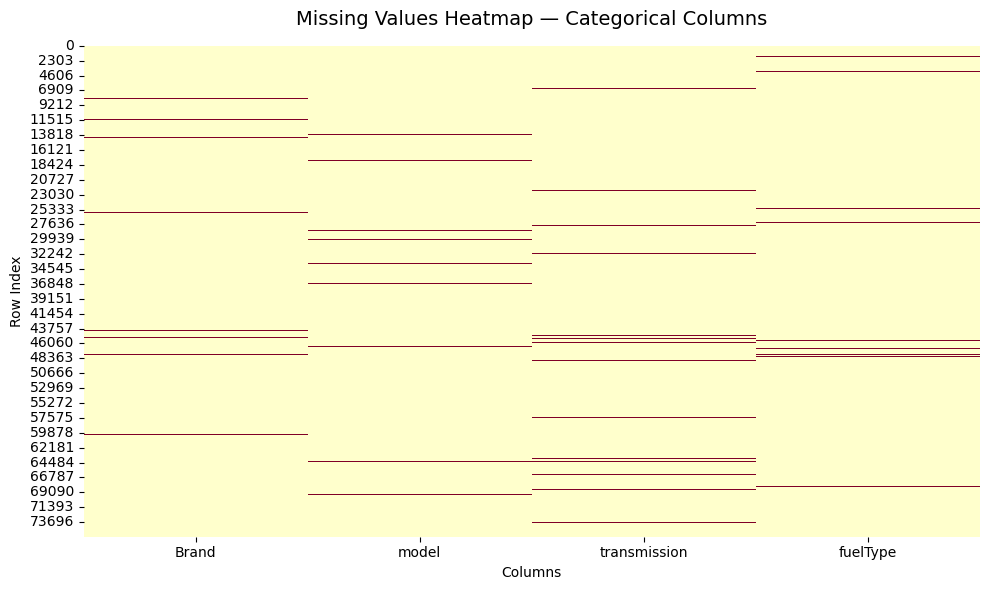

In [8]:
missing_cats = (
    cars[cat_cols]
    .apply(lambda x: x.isna() | x.astype(str).str.strip().isin(["", "nan", "none", "null", "NaN", "None"]))
    .sum()
)
missing_cats = missing_cats[missing_cats > 0].sort_values(ascending=False)

print("Missing Values in Categorical Columns:\n")
display(missing_cats.to_frame("Missing Count"))

missing_counts = cars[cat_cols].isna().sum()
missing_percent = (missing_counts / len(cars)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_percent
}).sort_values(by='Missing Count', ascending=False)
missing_df = missing_df[missing_df['Missing Count'] > 0]

print("Missing Values in Categorical Columns:\n")
display(missing_df)

plt.figure(figsize=(8, 5))
sns.barplot(x=missing_df.index, y=missing_df['Missing %'], color='salmon')
plt.title("Percentage of Missing Values — Categorical Columns", fontsize=14, pad=15)
plt.ylabel("Missing Values (%)")
plt.xlabel("Categorical Features")
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(cars[cat_cols].isna(), cbar=False, cmap="YlOrRd")
plt.title("Missing Values Heatmap — Categorical Columns", fontsize=14, pad=15)
plt.xlabel("Columns")
plt.ylabel("Row Index")
plt.tight_layout()
plt.show()

,Missing Count,Missing %
mpg,7924,10.430570
tax,7902,10.401611
previousOwners,1550,2.040306
hasDamage,1548,2.037673
paintQuality%,1524,2.006081
engineSize,1516,1.995551
year,1491,1.962643
mileage,1462,1.924469


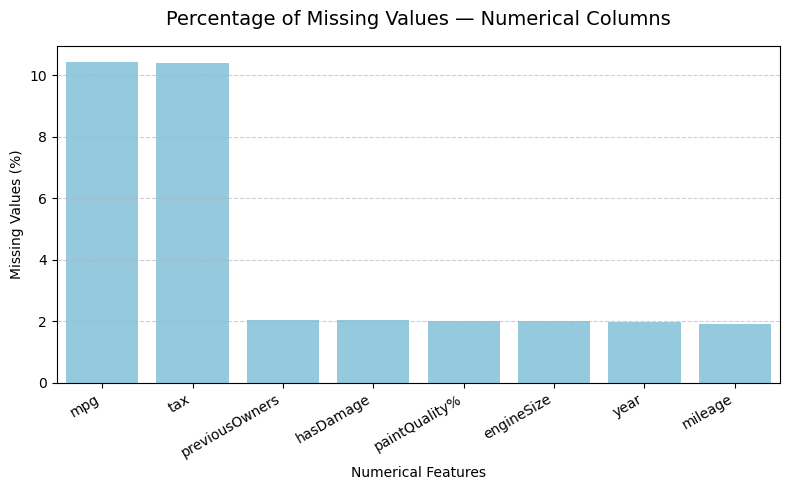

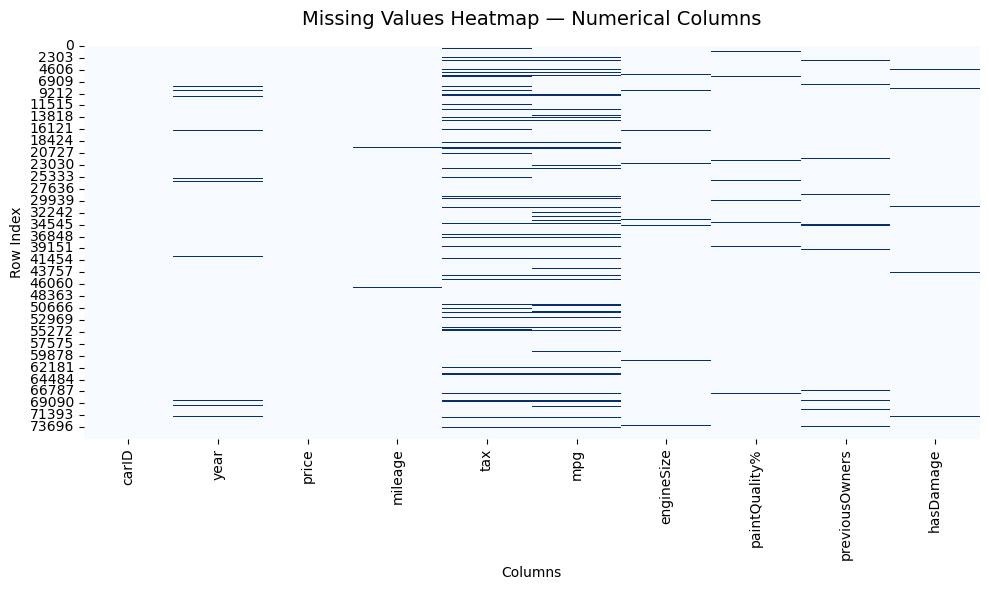

In [9]:
missing_counts = cars[num_cols].isna().sum()
missing_percent = (missing_counts / len(cars)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_percent
}).sort_values(by='Missing Count', ascending=False)
missing_df = missing_df[missing_df['Missing Count'] > 0]

display(missing_df)

plt.figure(figsize=(8, 5))
sns.barplot(x=missing_df.index, y=missing_df['Missing %'], color='skyblue')
plt.title("Percentage of Missing Values — Numerical Columns", fontsize=14, pad=15)
plt.ylabel("Missing Values (%)")
plt.xlabel("Numerical Features")
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(cars[num_cols].isna(), cbar=False, cmap="Blues")
plt.title("Missing Values Heatmap — Numerical Columns", fontsize=14, pad=15)
plt.xlabel("Columns")
plt.ylabel("Row Index")
plt.tight_layout()
plt.show()


## Overall Missing Values Summary

We generate a final consolidated list of all features (both numerical and categorical) that contain missing values, sorted by the count of missing entries.

In [10]:
print("\nMissing Value Summary:")
missing = cars.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if len(missing) == 0:
    print(" No missing values detected!")
else:
    display(missing.to_frame("Missing Count"))


Missing Value Summary:


,Missing Count
mpg,7924
tax,7902
previousOwners,1550
hasDamage,1548
paintQuality%,1524
transmission,1522
Brand,1521
model,1517
engineSize,1516
fuelType,1511


## Univariate Analysis: Feature Distributions

We analyze the distribution of individual variables to understand the data structure, detect skewness, and identify outliers.

* **Numerical Features:** For each continuous variable (excluding `carID`), we generate two plots:
    * **Histogram with KDE:** To visualize the shape of the data distribution (e.g., normal vs. skewed).
    * **Boxplot:** To visualize the central tendency and explicitly identify **outliers**.
* **Categorical Features:** We use count plots to show the frequency of different categories. To ensure readability for high-cardinality features, we limit the plots to the **top 15 most frequent categories**.

Numeric columns (10): ['carID', 'year', 'price', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'hasDamage']
Categorical columns (4): ['Brand', 'model', 'transmission', 'fuelType']

 Numeric Feature Distributions


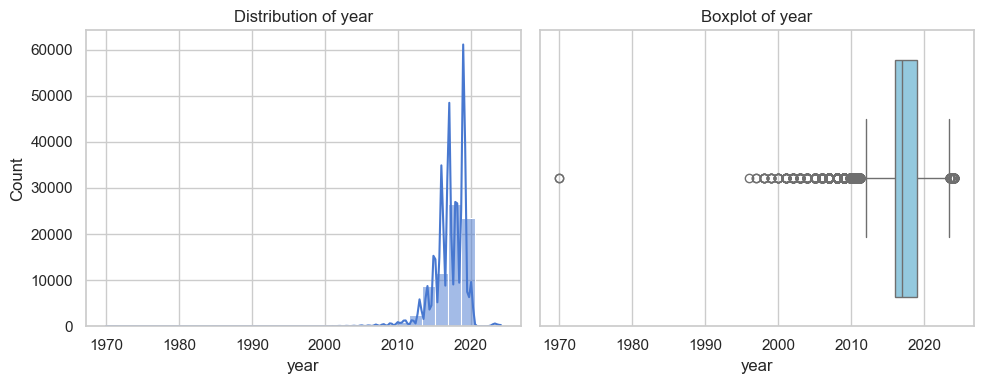

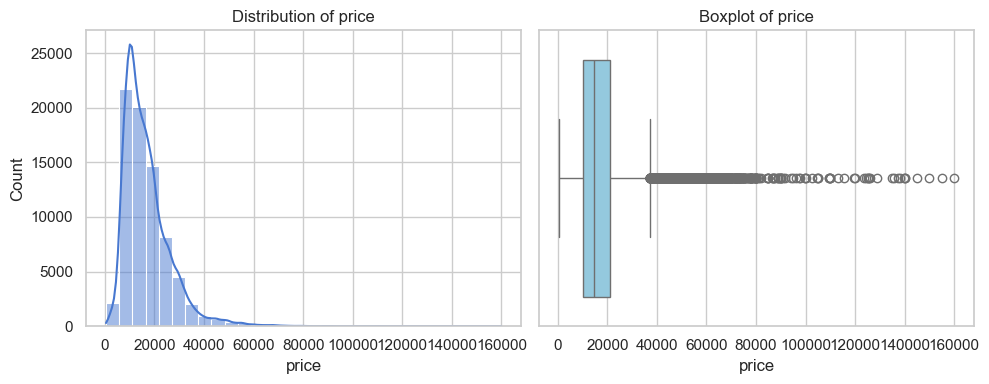

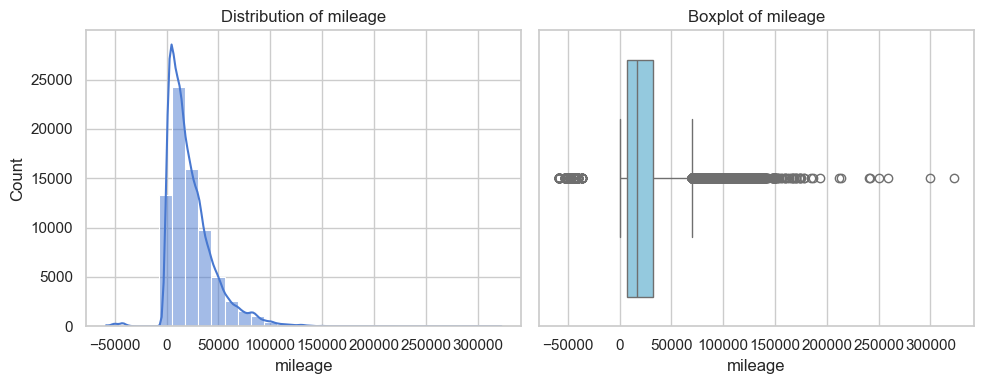

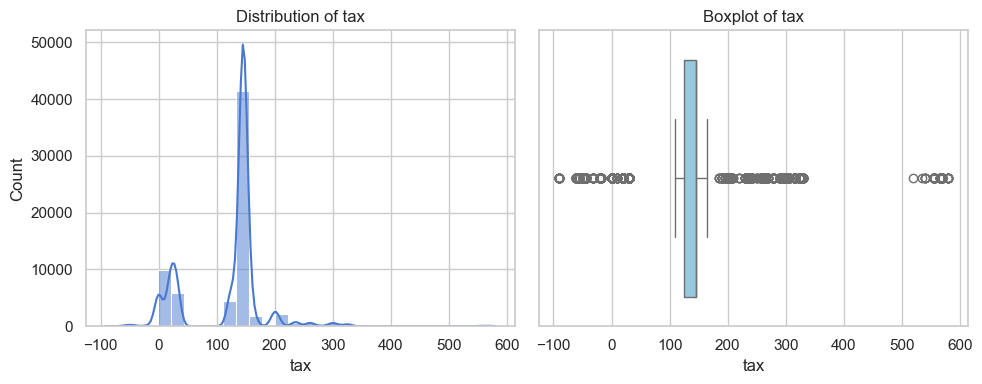

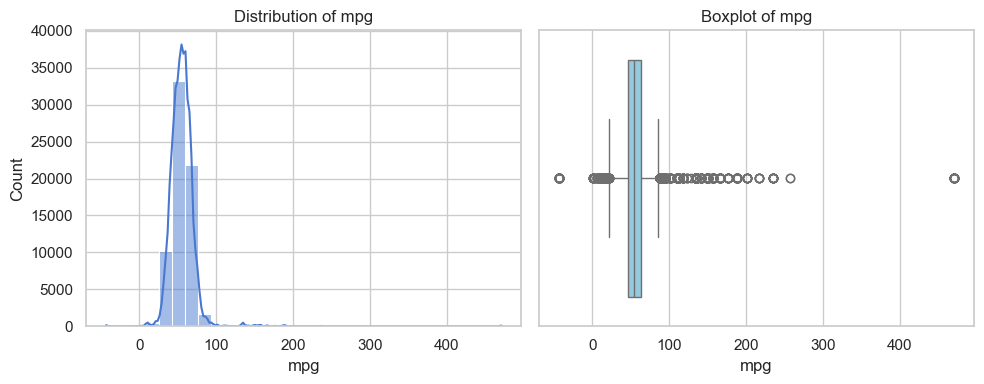

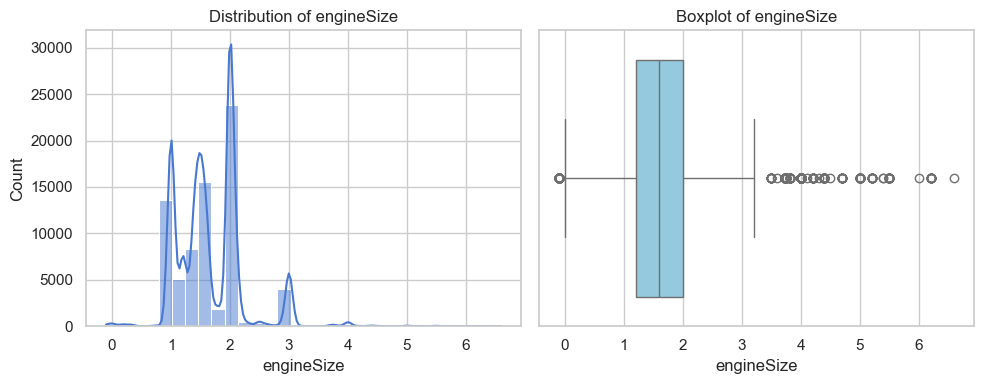

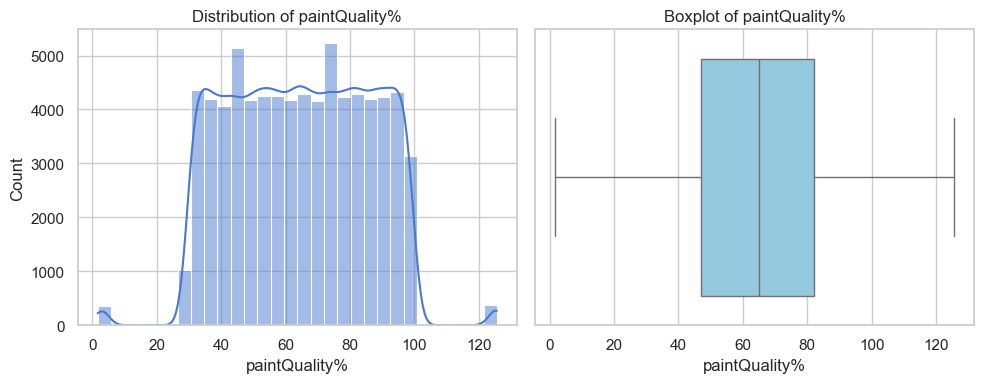

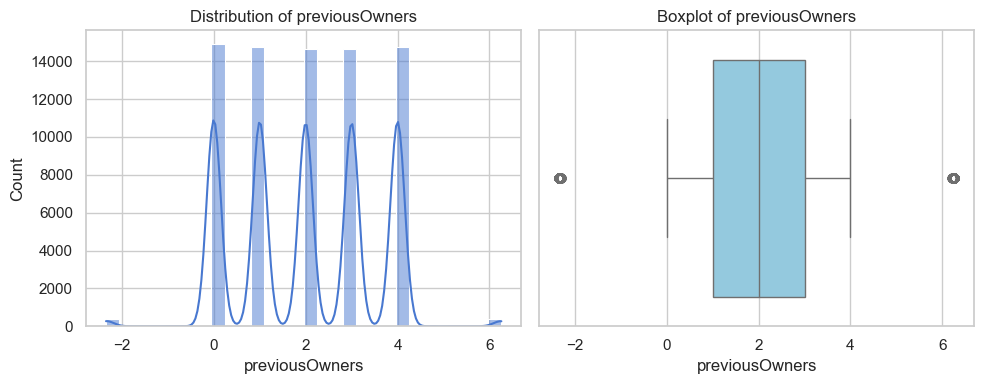

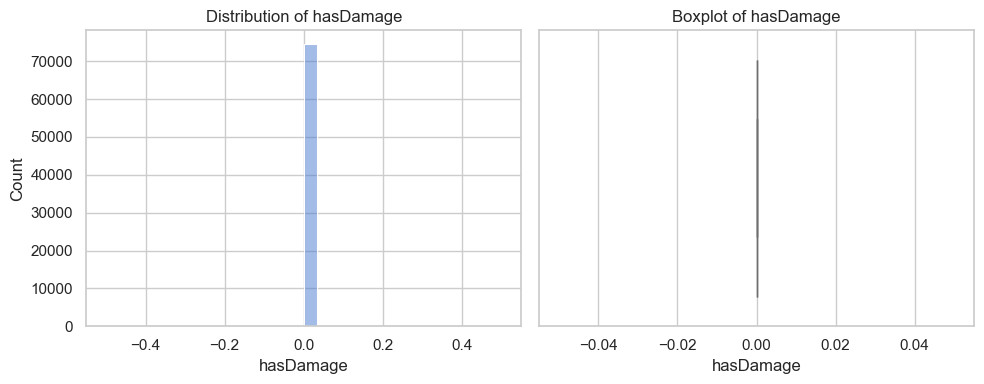


Categorical Feature Distributions


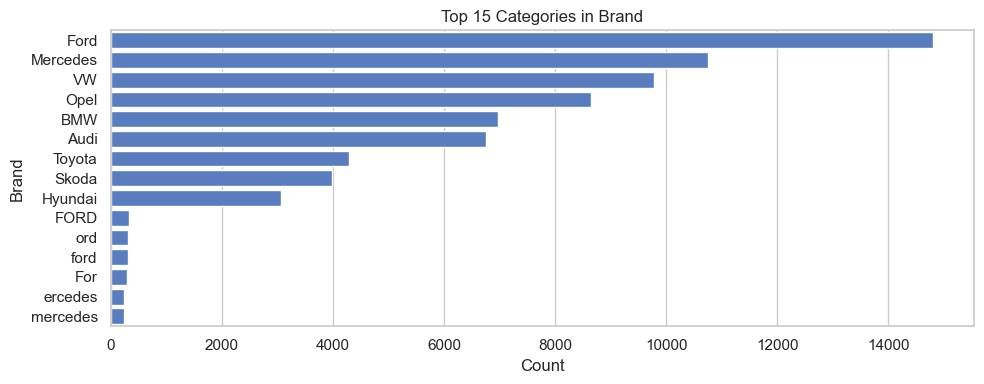

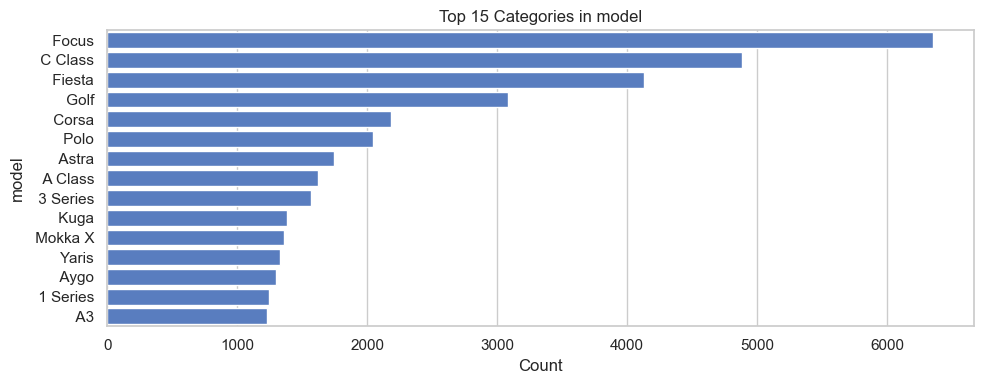

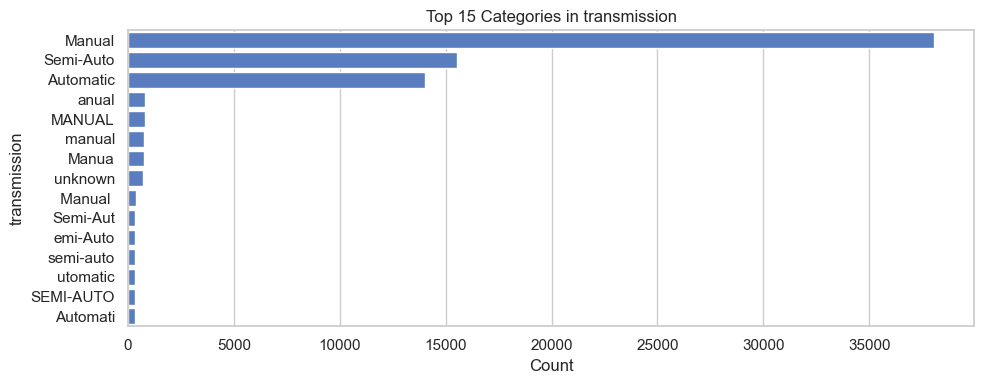

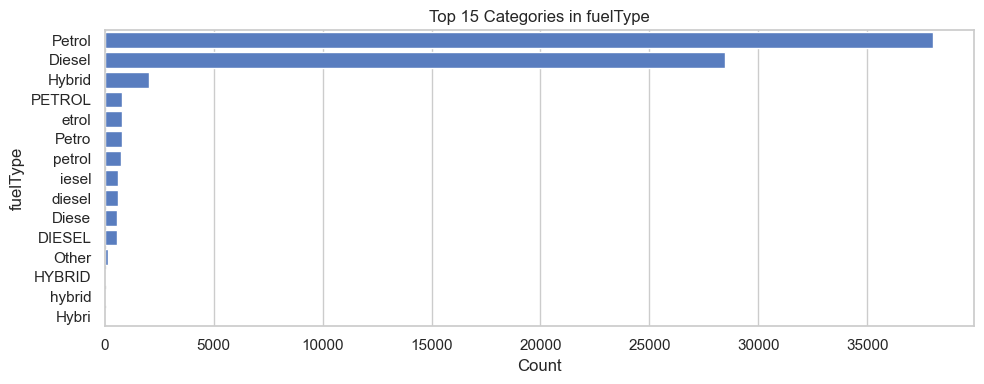

In [11]:
sns.set(style="whitegrid", palette="muted", color_codes=True)

print(f"Numeric columns ({len(num_cols)}): {num_cols}")
print(f"Categorical columns ({len(cat_cols)}): {cat_cols}")

print("\n Numeric Feature Distributions")

for col in num_cols:
    if col == "carID":
        continue
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(cars[col].dropna(), kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

    plt.subplot(1, 2, 2)
    sns.boxplot(x=cars[col], color='skyblue')
    plt.title(f"Boxplot of {col}")

    plt.tight_layout()
    plt.show()

print("\nCategorical Feature Distributions")

for col in cat_cols:
    plt.figure(figsize=(10, 4))
    order = cars[col].value_counts().index[:15]
    sns.countplot(data=cars, y=col, order=order)
    plt.title(f"Top {len(order)} Categories in {col}")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

## Categorical Feature Selection: Chi-Square Test

We perform a Chi-Square Test to determine if there is a significant relationship between each categorical feature and the target variable.

We compare the p-value against a significance level (alpha) of 0.05:
* **p < 0.05:** The feature has a strong relationship with the target and is kept as **Important**.
* **p >= 0.05:** The feature is likely independent of the target and is flagged to be **Discarded**.

In [12]:
def TestIndependence(X, y, var, alpha=0.05):        
    dfObserved = pd.crosstab(y, X) 
    chi2, p, dof, expected = chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index=dfObserved.index)
    
    if p < alpha:
        result = f"{var} is IMPORTANT for Prediction"
    else:
        result = f"{var} is NOT an important predictor. (Discard {var} from model)"
    print(result)


target = 'price'

for var in cat_cols:
    TestIndependence(cars[var], cars[target], var)

Brand is NOT an important predictor. (Discard Brand from model)
model is IMPORTANT for Prediction
transmission is IMPORTANT for Prediction
fuelType is NOT an important predictor. (Discard fuelType from model)


## Correlation Heatmap

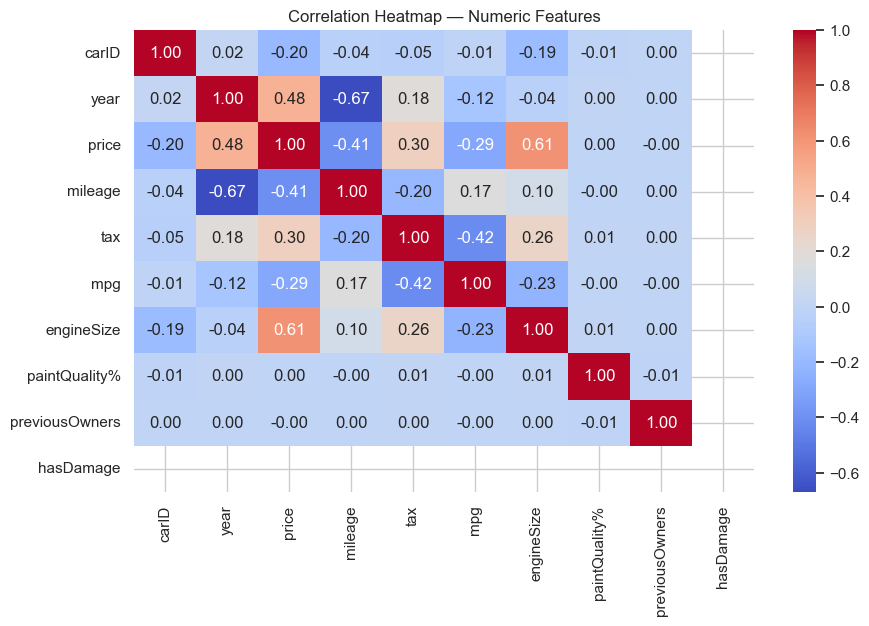

In [13]:
plt.figure(figsize=(10,6))
sns.heatmap(cars[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap — Numeric Features")
plt.show()

## Summary Statistics

In [14]:
cars.describe().T

,count,mean,std,min,25%,50%,75%,max
carID,75969.0,37986.478419,21932.101848,0.000000,18992.0,37988.0,56980.0,75972.000000
year,74478.0,2017.096576,2.208750,1970.000000,2016.0,2017.0,2019.0,2024.121759
price,75969.0,16882.001922,9737.075658,450.000000,10200.0,14699.0,20950.0,159999.000000
mileage,74507.0,23004.761128,22130.041696,-58540.574478,7423.5,17301.0,32428.0,323000.000000
tax,68067.0,120.328500,65.522046,-91.121630,125.0,145.0,145.0,580.000000
mpg,68045.0,55.152286,16.497834,-43.421768,46.3,54.3,62.8,470.800000
engineSize,74453.0,1.660161,0.573464,-0.103493,1.2,1.6,2.0,6.600000
paintQuality%,74445.0,64.591773,21.020975,1.638913,47.0,65.0,82.0,125.594308
previousOwners,74419.0,1.994485,1.472961,-2.345650,1.0,2.0,3.0,6.258371
hasDamage,74421.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


## 1. EDA Findings

### Data Issues Summary

After checking the raw data and statistics, we found problems that need to be fixed before we train the model:

#### Data Errors
* Impossible Numbers: Columns like mileage, tax, and previousOwners have negative values, which is impossible. We must correct these.
* Impossible Dates: The year column has dates that are too far in the future. We will fix these years.
* Suspicious Zeros: Some cars show 0 mileage or 0 engine size when they shouldn't.

#### Missing Data
* Many columns, including tax, mpg, and some car details, have missing values (NaN). We need to fill these gaps.

#### Outliers and Skewness
* The price column has extreme high values (outliers) that make it heavily skewed. We need to use a log transformation to fix this.
* Other features are also skewed and have outliers that need to be clipped.

---

### Insights from Visual Charts

We used charts to see the data visually, which helped us find strong relationships.

#### Single Variable Checks
* Price: The chart confirmed the price is pulled up by expensive cars.
* Mileage: Most cars have low mileage, but we need to cut down the extreme high-mileage outliers.

#### All Variables Together (The Color Map)
* Best Predictors: The car's Age and Mileage are the most important numbers for predicting price.

These findings show us exactly how to start the data cleaning and fixing process in the next steps.

# Train - Test split

In [15]:
Y = cars['price']
X = cars.drop(columns=['price', 'carID'])
num_cols_new = X.select_dtypes(include=[np.number]).columns
num_cols_new_test = X.select_dtypes(include=[np.number]).columns
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42,)

# Data Cleaning: Numerical Features

We implement a cleaning pipeline to sanitize numerical data. Instead of deleting rows with errors, we replace invalid values with `NaN` (Missing Values), allowing us to handle them systematically during the imputation phase.

## A. Handling Invalid Numbers
1. **Negative Values:** We scan all numerical features (excluding the target `price`). Any negative value is treated as a data entry error and replaced with `NaN`.
2. **Invalid Zeros:**
    * **Allowed Zeros:** We preserve legitimate zeros in specific columns: `previousOwners`, `hasDamage` (boolean), `tax`, and `engineSize` (only if the car is Electric).
    * **Suspicious Zeros:** For all other columns, zero values are considered missing information and replaced with `NaN`.

## B. Domain-Specific Validation
1. **Registration Year:** We validate the `year` column. Any year greater than 2020 (future dates relative to the dataset) is marked as `NaN`.
2. **Engine Size Constraints:** We enforce a minimum engine size of **0.6L** for non-electric vehicles. Values below this threshold are likely errors and are replaced with `NaN`.

In [16]:
def fix_negative_values(df, num_cols, target_col='price', threshold=0.7):
    df = df.copy()
    for col in num_cols:
        if col.lower() == target_col.lower():
            continue
        df.loc[df[col] < 0, col] = np.nan
    return df

valid_zero_cols = ['previousOwners', 'hasDamage', 'tax']

def replace_zero_with_nan(df, num_cols):
    df = df.copy()
    for col in num_cols:
        if col not in df.columns:
            continue
        if col in valid_zero_cols:
            continue
        if col == 'engineSize' and 'fuelType' in df.columns:
            mask = (df[col] == 0) & (df['fuelType'].str.lower() != 'electric')
        else:
            mask = (df[col] == 0)
        zero_count = mask.sum()
        if zero_count > 0:
            df.loc[mask, col] = np.nan
    return df


def fix_year_values(df):
    df['year'] = np.floor(df['year'])
    df.loc[df['year'] > 2020, 'year'] = np.nan
    return df


def fix_engine_size_values(df):
    df.loc[(df['engineSize'] < 0.6) & (df['fuelType'].str.lower() != 'electric'), 'engineSize'] = np.nan
    return df


def apply_numerical_data_cleaning(df, num_cols):
    df = fix_negative_values(df, num_cols)
    df = replace_zero_with_nan(df, num_cols)
    df = fix_year_values(df)
    df = fix_engine_size_values(df)
    return df

X_train = apply_numerical_data_cleaning(X_train, num_cols_new)
X_test = apply_numerical_data_cleaning(X_test, num_cols_new)

## Categorical Feature Engineering & Cleaning

Before encoding variables for the model, we perform three layers of text processing to reduce noise and dimensionality. This pipeline is fitted on the **Training Set** and then applied to the **Test Set** to prevent data leakage.

### The Steps We Took

1.  **Text Normalization:**
    * We standardize all text to lowercase, remove periods, and collapse extra spaces.
    * We fill missing or null-like values (e.g., "nan", "none") with a placeholder label `"unknown"`.
    
2.  **Category Unification (Substring Mapping):**
    * We detect categories that are substrings of one another (e.g., "Standard" vs. "Standard Model").
    * To fix inconsistencies, we merge these overlapping variations into the most frequent representative version. 

3.  **Handling Rare Categories:**
    * **The Problem:** Categories with very few samples (less than 30 occurrences) introduce noise and can cause the model to overfit.
    * **The Solution:** We group these rare categories into a single label: `"other"`. This significantly reduces the number of columns created during One-Hot Encoding later.

### Outcome
This process results in a clean, consistent set of categorical features where redundant variations are merged and noisy outliers are removed.

In [17]:
def normalize_text(df, columns=None):
    df = df.copy()
    columns = columns or df.select_dtypes(include="object").columns
    for col in columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.lower()
            .str.strip()
            .str.replace(r"\s+", " ", regex=True)
            .str.replace(".", "", regex=False)
            .replace(["nan", "none", "na", "n/a", "", "null", "unknown"], "unknown")
        )
    return df


def fit_substring_maps(df):
    maps = {}
    for col in df.select_dtypes(include="object").columns:
        unique_vals = df[col].dropna().unique().tolist()
        freq = df[col].value_counts()
        mapping = {}
        used = set()

        for val in unique_vals:
            if val in used:
                continue
            matches = [x for x in unique_vals if (val in x or x in val)]
            if len(matches) < 2:
                continue
            used.update(matches)
            rep = max(matches, key=lambda x: (freq.get(x, 0), len(x)))
            for m in matches:
                mapping[m] = rep

        maps[col] = mapping
    return maps


def apply_substring_maps(df, maps):
    df = df.copy()
    for col, mapping in maps.items():
        if col in df.columns and mapping:
            df[col] = df[col].replace(mapping)
    return df


def fit_rare_category_maps(df, threshold=30, other_label="other"):
    maps = {}
    for col in df.select_dtypes(include="object").columns:
        freq = df[col].value_counts()
        rare = freq[freq < threshold].index.tolist()
        maps[col] = rare
    return maps


def apply_rare_category_maps(df, maps, other_label="other"):
    df = df.copy()
    for col, rare in maps.items():
        if col in df.columns and rare:
            df[col] = df[col].replace(rare, other_label)
    return df


def preprocess_text_train(df, threshold=30):
    df = normalize_text(df)
    substring_maps = fit_substring_maps(df)
    df = apply_substring_maps(df, substring_maps)
    rare_maps = fit_rare_category_maps(df, threshold)
    df = apply_rare_category_maps(df, rare_maps)
    return df, substring_maps, rare_maps


def preprocess_text_test(df, substring_maps, rare_maps):
    df = normalize_text(df)
    df = apply_substring_maps(df, substring_maps)
    df = apply_rare_category_maps(df, rare_maps)
    return df


def summarize_categorical(df, max_values=30):
    for col in df.select_dtypes(include="object").columns:
        print(f"\n--- Column: {col} ---")
        print(df[col].value_counts(dropna=False).head(max_values).to_markdown())

X_train, substring_maps, rare_maps = preprocess_text_train(X_train, threshold=30)
X_test = preprocess_text_test(X_test, substring_maps, rare_maps)

summarize_categorical(X_train)


--- Column: Brand ---
| Brand    |   count |
|:---------|--------:|
| ford     |   11239 |
| mercedes |    8203 |
| vw       |    7144 |
| opel     |    6621 |
| bmw      |    5146 |
| audi     |    5106 |
| toyota   |    3240 |
| skoda    |    3001 |
| hyundai  |    2282 |
| unknown  |    1196 |

--- Column: model ---
| model     |   count |
|:----------|--------:|
| focus     |    4859 |
| c class   |    3666 |
| fiesta    |    3129 |
| golf      |    2483 |
| corsa     |    1671 |
| polo      |    1569 |
| mokka x   |    1437 |
| astra     |    1336 |
| a class   |    1216 |
| 3 series  |    1181 |
| e class   |    1140 |
| unknown   |    1055 |
| kuga      |    1051 |
| aygo      |    1000 |
| yaris     |     990 |
| 1 series  |     959 |
| tiguan    |     889 |
| a3        |     887 |
| a         |     803 |
| up        |     774 |
| fabia     |     753 |
| octavia   |     724 |
| q3        |     695 |
| a4        |     633 |
| a1        |     624 |
| tucson    |     623 |
| 2 se

## Handling Missing Values (Imputation)

We implement a two-tiered imputation strategy to handle missing data without introducing data leakage. All statistics (medians, modes, and mappings) are calculated solely on the **Training Set** and then applied to the Test Set.

### A. Numerical Imputation
* **Method:** We fill missing values in numerical columns (e.g., `mileage`, `tax`) using the **Median**.
* **Reasoning:** The median is robust to outliers, which we identified in the previous Univariate Analysis step. Using the mean would be risky due to the skewness of these features.

### B. Categorical Imputation: Hierarchical Fallback
Instead of blindly filling missing text with the most common value (e.g., assuming every missing car is a "Ford"), we use a **Context-Aware Hierarchical Imputation**.

**How it works:**
We define a dependency hierarchy for each column. The system tries to find the most frequent value (mode) based on specific groupings, falling back to broader groups if necessary:

1.  **Level 1 (Specific):** Try to guess the missing value using highly specific related features.
    * *Example:* To guess a missing `model`, we look at the combination of `Brand` + `engineSize` + `year` + `fuelType`.
2.  **Level 2 (Broader):** If Level 1 is missing (e.g., we've never seen that specific engine/year combo), we drop one variable and try again.
    * *Example:* Look at `Brand` + `engineSize` + `fuelType`.
3.  **Global Fallback:** If all specific groups fail, we fill the remaining gaps with the **Global Mode** (the most frequent category in the entire column).



### C. Text Normalization
Before imputation, we strictly clean categorical strings by:
* Converting to lowercase.
* Stripping whitespace.
* Converting placeholder text (e.g., "unknown", "n/a", "none") into actual `NaN` values so our imputer can catch and fix them.

In [18]:
categorical_group_hierarchy = {
    "Brand":[
        ["model"]
    ],
    "model": [
        ["Brand", "engineSize", "year", "fuelType"],
        ["Brand", "engineSize", "fuelType"],
        ["Brand", "engineSize"],
        ["Brand"],
    ],
    "transmission": [
        ["model", "engineSize", "fuelType"],
        ["model", "fuelType"],
        ["model"],
    ],
    "fuelType": [
        ["model", "engineSize"],
        ["model"],
    ],
}


def clean_categoricals(df):
    df = df.copy()
    for col in df.select_dtypes(include="object").columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.lower()
            .str.strip()
            .replace(["nan", "none", "na", "n/a", "", "null", "unknown"], np.nan)
        )
    return df


def fit_numeric_imputer(X_train, num_cols, strategy="median"):
    imputer = SimpleImputer(strategy=strategy)
    imputer.fit(X_train[num_cols])
    return imputer


def apply_numeric_imputer(df, num_cols, imputer):
    df = df.copy()
    df[num_cols] = imputer.transform(df[num_cols])
    return df


def fit_hierarchical_group_modes(X_train, hierarchy):
    maps = {}

    for col, levels in hierarchy.items():
        if col not in X_train.columns:
            continue

        col_maps = []
        for deps in levels:
            deps = [d for d in deps if d in X_train.columns]
            if not deps:
                continue

            mode_map = (
                X_train
                .dropna(subset=[col])
                .groupby(deps)[col]
                .agg(lambda x: x.mode().iloc[0])
            )
            col_maps.append((deps, mode_map))

        global_mode = X_train[col].mode()
        global_mode = global_mode.iloc[0] if not global_mode.empty else np.nan
        col_maps.append(([], global_mode))

        maps[col] = col_maps

    return maps


def apply_hierarchical_group_modes(df, hierarchical_maps):
    df = df.copy()

    for col, levels in hierarchical_maps.items():
        if col not in df.columns:
            continue

        missing = df[col].isna()

        for deps, mapping in levels:

            if deps:
                filled = (
                    df.loc[missing, deps]
                    .merge(
                        mapping.rename(col),
                        left_on=deps,
                        right_index=True,
                        how="left"
                    )[col]
                    .values
                )
            else:
                filled = mapping

            df.loc[missing, col] = filled
            missing = df[col].isna()

    return df


def fit_categorical_imputer(X_train, hierarchy):
    cat_cols = [c for c in hierarchy.keys() if c in X_train.columns]
    imputer = SimpleImputer(strategy="most_frequent")
    imputer.fit(X_train[cat_cols])
    return imputer, cat_cols


def apply_categorical_imputer(df, cat_cols, imputer):
    df = df.copy()
    df[cat_cols] = imputer.transform(df[cat_cols])
    return df


def preprocess_train(X_train, num_cols):
    X_train = clean_categoricals(X_train)

    num_imputer = fit_numeric_imputer(X_train, num_cols)
    X_train = apply_numeric_imputer(X_train, num_cols, num_imputer)

    hierarchical_maps = fit_hierarchical_group_modes(
        X_train,
        categorical_group_hierarchy
    )
    X_train = apply_hierarchical_group_modes(X_train, hierarchical_maps)

    cat_imputer, cat_cols = fit_categorical_imputer(
        X_train,
        categorical_group_hierarchy
    )
    X_train = apply_categorical_imputer(X_train, cat_cols, cat_imputer)

    return X_train, num_imputer, hierarchical_maps, cat_imputer, cat_cols


def preprocess_test(X_test, num_cols, num_imputer, hierarchical_maps, cat_imputer, cat_cols):
    X_test = clean_categoricals(X_test)
    X_test = apply_numeric_imputer(X_test, num_cols, num_imputer)
    X_test = apply_hierarchical_group_modes(X_test, hierarchical_maps)
    X_test = apply_categorical_imputer(X_test, cat_cols, cat_imputer)
    return X_test


X_train, num_imputer, hierarchical_maps, cat_imputer, cat_cols = preprocess_train(
    X_train,
    num_cols_new
)

X_test = preprocess_test(
    X_test,
    num_cols_new,
    num_imputer,
    hierarchical_maps,
    cat_imputer,
    cat_cols
)


### Post-Imputation Verification

We perform a final quality check to confirm that our imputation strategies were successful.

**Objective:**
* Ensure the count of missing values (`NaN`) is **zero** for all numerical and categorical features.
* Validate that the training and test sets are complete and ready for encoding and modeling.

In [19]:
for col in categorical_group_hierarchy.keys():
    if col in X_train.columns:
        remaining = X_train[col].isna().sum()
        print(f"Training Data -- {col}: {remaining}")

missing = X_train[num_cols_new].isna().sum().sort_values(ascending=False)
print("Missing values in Train numeric columns after imputation:\n")
display(missing.to_frame("Missing Train Count"))

Training Data -- Brand: 0
Training Data -- model: 0
Training Data -- transmission: 0
Training Data -- fuelType: 0
Missing values in Train numeric columns after imputation:



,Missing Train Count
year,0
mileage,0
tax,0
mpg,0
engineSize,0
paintQuality%,0
previousOwners,0
hasDamage,0


## Categorical Features Encoding: Target Encoding

We use **Target Encoding** to convert categorical variables (like `model`) into numerical values based on the mean target price.

* **Efficiency:** Effectively handles high-cardinality features without creating excessive columns (unlike One-Hot Encoding).
* **Regularization:** We apply **smoothing** (`0.3`) and a **minimum sample threshold** (`20`) to prevent overfitting on rare categories.
* **Leakage Prevention:** The encoder is fitted solely on the **Training Set** and then applied to the Test Set to ensure data integrity.

In [20]:
cat_cols = X_train.select_dtypes(exclude=["number"]).columns.tolist()

te = ce.TargetEncoder(
    cols=cat_cols,
    smoothing=0.3,
    min_samples_leaf=20
)

X_train_te = te.fit_transform(X_train[cat_cols], y_train)
X_train_te = pd.DataFrame(
    X_train_te,
    columns=cat_cols,
    index=X_train.index
)

X_train = pd.concat(
    [X_train.drop(columns=cat_cols), X_train_te],
    axis=1
)

X_test_te = te.transform(X_test[cat_cols])
X_test_te = pd.DataFrame(
    X_test_te,
    columns=cat_cols,
    index=X_test.index
)
X_test = pd.concat(
    [X_test.drop(columns=cat_cols), X_test_te],
    axis=1
)


## Statiscal Shape after filling missing values

In [21]:
X_train[num_cols_new].describe()

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
count,53178.000000,53178.000000,53178.000000,53178.000000,53178.000000,53178.000000,53178.000000,53178.0
mean,2017.060551,23159.889513,124.053346,55.097021,1.669379,64.670141,2.011629,0.0
std,2.142326,21399.450344,61.530183,15.624412,0.554850,20.785519,1.426936,0.0
min,1997.000000,1.000000,0.000000,1.100000,0.600000,1.638913,0.000000,0.0
25%,2016.000000,7730.500000,125.000000,47.100000,1.300000,47.000000,1.000000,0.0
50%,2017.000000,17343.000000,145.000000,54.300000,1.600000,65.000000,2.000000,0.0
75%,2019.000000,32000.000000,145.000000,61.400000,2.000000,82.000000,3.000000,0.0
max,2020.000000,323000.000000,580.000000,470.800000,6.600000,125.594308,6.258371,0.0


## Feature Engineering & Correlation Analysis

We create new synthetic features to capture relationships that raw variables might miss. This transformation is applied independently to both training and test sets to maintain consistency.

### 1. Created Features
* **Vehicle Age:** Calculated relative to the current year. This serves as a better proxy for depreciation than the raw `year`.
* **Annual Mileage:** (`mileage / age`) Represents the intensity of usage. A car driven 100k miles in 2 years is very different from one driven 100k miles in 10 years.
* **Efficiency Ratio:** A log-transformed ratio of `mpg` to `engineSize`. This creates a balanced metric distinguishing high-efficiency commuters from high-performance vehicles.

### 2. Correlation Inspection
After adding these features, we update our numerical column list and generate a **Heatmap** to inspect correlations.
* **Objective:** We specifically look for **strong correlations (> 0.75)**. High correlation between features (multicollinearity) can destabilize linear models, so this check informs our subsequent feature selection steps.

In [22]:
def add_features(df):
    df = df.copy()
    current_year = datetime.now().year + 1
    df['age'] = current_year - df['year']
    df['mileage_per_year'] = df['mileage'] / (df['age'] + 1)
    df['efficiency_ratio'] = np.log1p(df['mpg'] / (df['engineSize'] + 1))
    return df

X_train = add_features(X_train)
X_test = add_features(X_test)

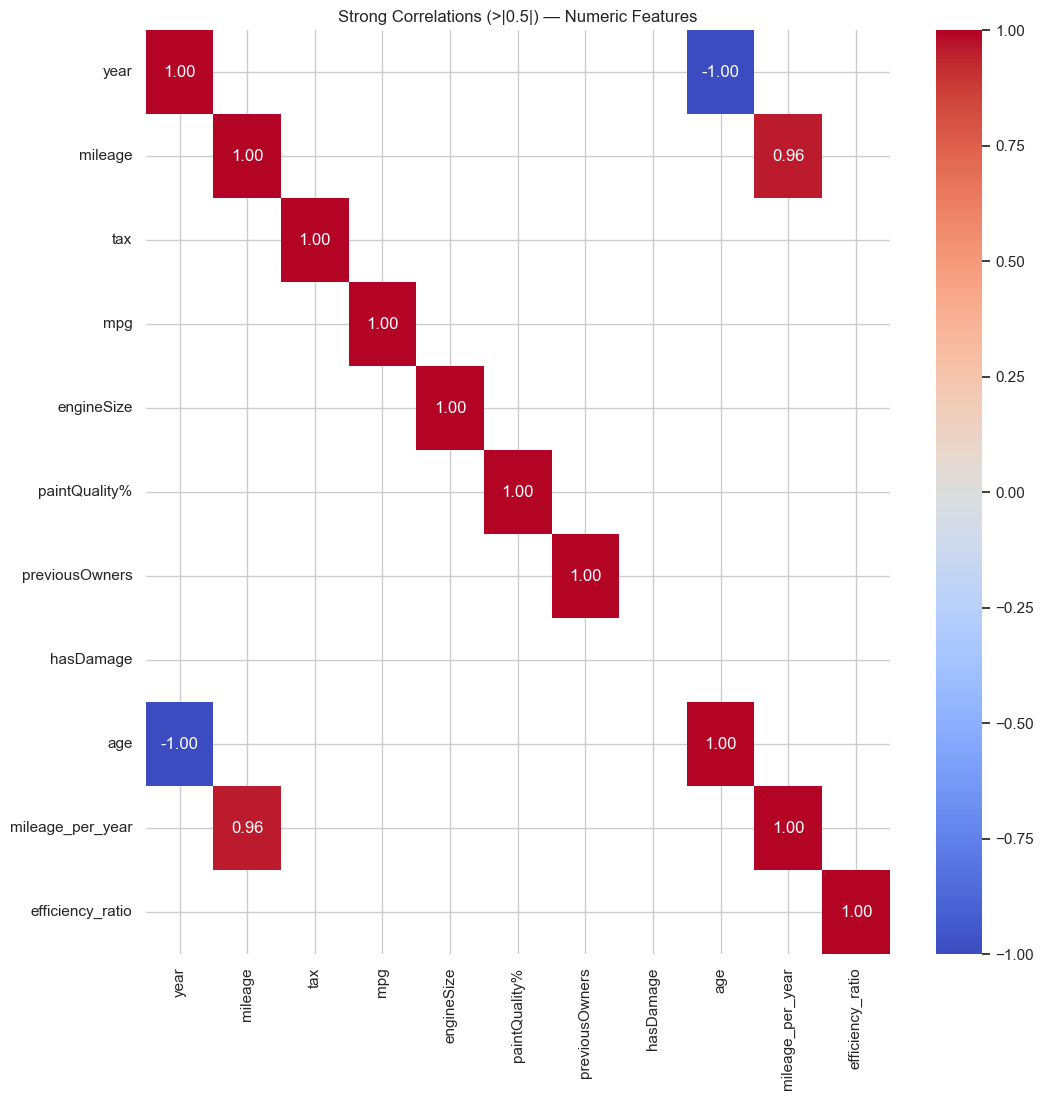

In [23]:
num_cols_new = num_cols_new.to_list()
num_cols_new.extend(['age', 'mileage_per_year', 'efficiency_ratio'])
corr_matrix = X_train[num_cols_new].corr()
strong_corr = corr_matrix[(corr_matrix > 0.75) | (corr_matrix < -0.75)]
plt.figure(figsize=(12, 12))
sns.heatmap(strong_corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Strong Correlations (>|0.5|) — Numeric Features")
plt.show()

## Log Transformation of the Target Feature i.e Price

In [24]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

### Feature Selection: Removing Redundant Features

Since we created `age` and `mileage_per_year`, keeping the original `year` and `mileage` columns would result in **double counting** the same information.

* **Action:** We remove `year` and `mileage` from the dataset.
* **Reasoning:** The new features capture the same underlying data but in a more useful format. Keeping the originals would just create noise and "confuse" the model by giving it two ways to measure the exact same thing (Redundancy).

In [25]:
def drop_highly_correlated_features(df):
    df = df.drop(columns=['year', 'mileage'], errors='ignore')
    return df
X_train = drop_highly_correlated_features(X_train)
X_test = drop_highly_correlated_features(X_test)

In [26]:
num_cols_new.remove('year')
num_cols_new.remove('mileage')

## Data Scaling: Standardization

We apply **Standard Scaling** to all numerical features (including our new engineered columns) to ensures they contribute equally to the model.

### Action Taken
We use `StandardScaler` to transform features so they follow a standard normal distribution (mean=0, std=1).
* **Implementation:** We calculate the scaling parameters (mean and variance) using the **Training Set**. We then use those stored statistics to transform the **Test Set**.

### Reasoning
1.  **Uniformity:** Raw features exist on vastly different scales. For example, `age` is a single digit ($\approx 5$), while `mileage` is in the thousands ($\approx 50,000$). Without scaling, Linear Regression would unfairly bias the model toward variables with larger raw numbers.
2.  **Model Stability:** Standardization ensures stable convergence during training and makes the resulting coefficients interpretable as comparable measures of feature importance.

In [27]:
def fit_scalers(X_train, numeric_cols):
    scaler = StandardScaler()
    X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    return scaler

scaler = fit_scalers(X_train, num_cols_new)

X_test[num_cols_new] = scaler.transform(X_test[num_cols_new])

## Feature Selection Summary

We refined our feature set through a combination of redundancy analysis and performance benchmarking (Validation MAE).

### 1. Features We Removed
We permanently dropped the following variables:
* **`year` & `mileage`:** Removed for Redundancy. These were strictly replaced by our engineered features `age` and `mileage_per_year` to avoid double-counting the same information.
* **`hasDamage`:** Removed for Irrelevance. This feature showed extremely low variance (almost entirely "False") and offered no predictive power during our initial screening.
* **`paintQuality%`:** Removed due to very less predictive pwoer during initial screening.
* **`previousOwners`:** Removed due to very less predictive pwoer during initial screening

### 2. Features We Kept (The "Performance" Decision)
We considered removing other features that showed weak correlation with price on our heatmap (e.g., `tax`, `mpg`, or specific encoded columns).

* **The Experiment:** We ran a validation test where we removed these "weak" features to see if a simpler model would perform better.
* **The Result:** Removing these features caused our **Mean Absolute Error (MAE) to increase** (i.e., prediction accuracy got worse).
* **Conclusion:** Even though these features appeared weak individually, they provide valuable context to the model (likely through interaction with other variables). To prioritize **lowest prediction error**, we decided to **retain all other features**.

In [28]:
corr_scores = X_train.corrwith(y_train).abs().sort_values(ascending=False)
corr_scores

/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


model               0.714689
engineSize          0.622854
efficiency_ratio    0.605482
transmission        0.557146
Brand               0.540279
age                 0.479967
mileage_per_year    0.375808
tax                 0.286299
mpg                 0.273201
fuelType            0.212714
paintQuality%       0.003469
previousOwners      0.003338
hasDamage                NaN
dtype: float64

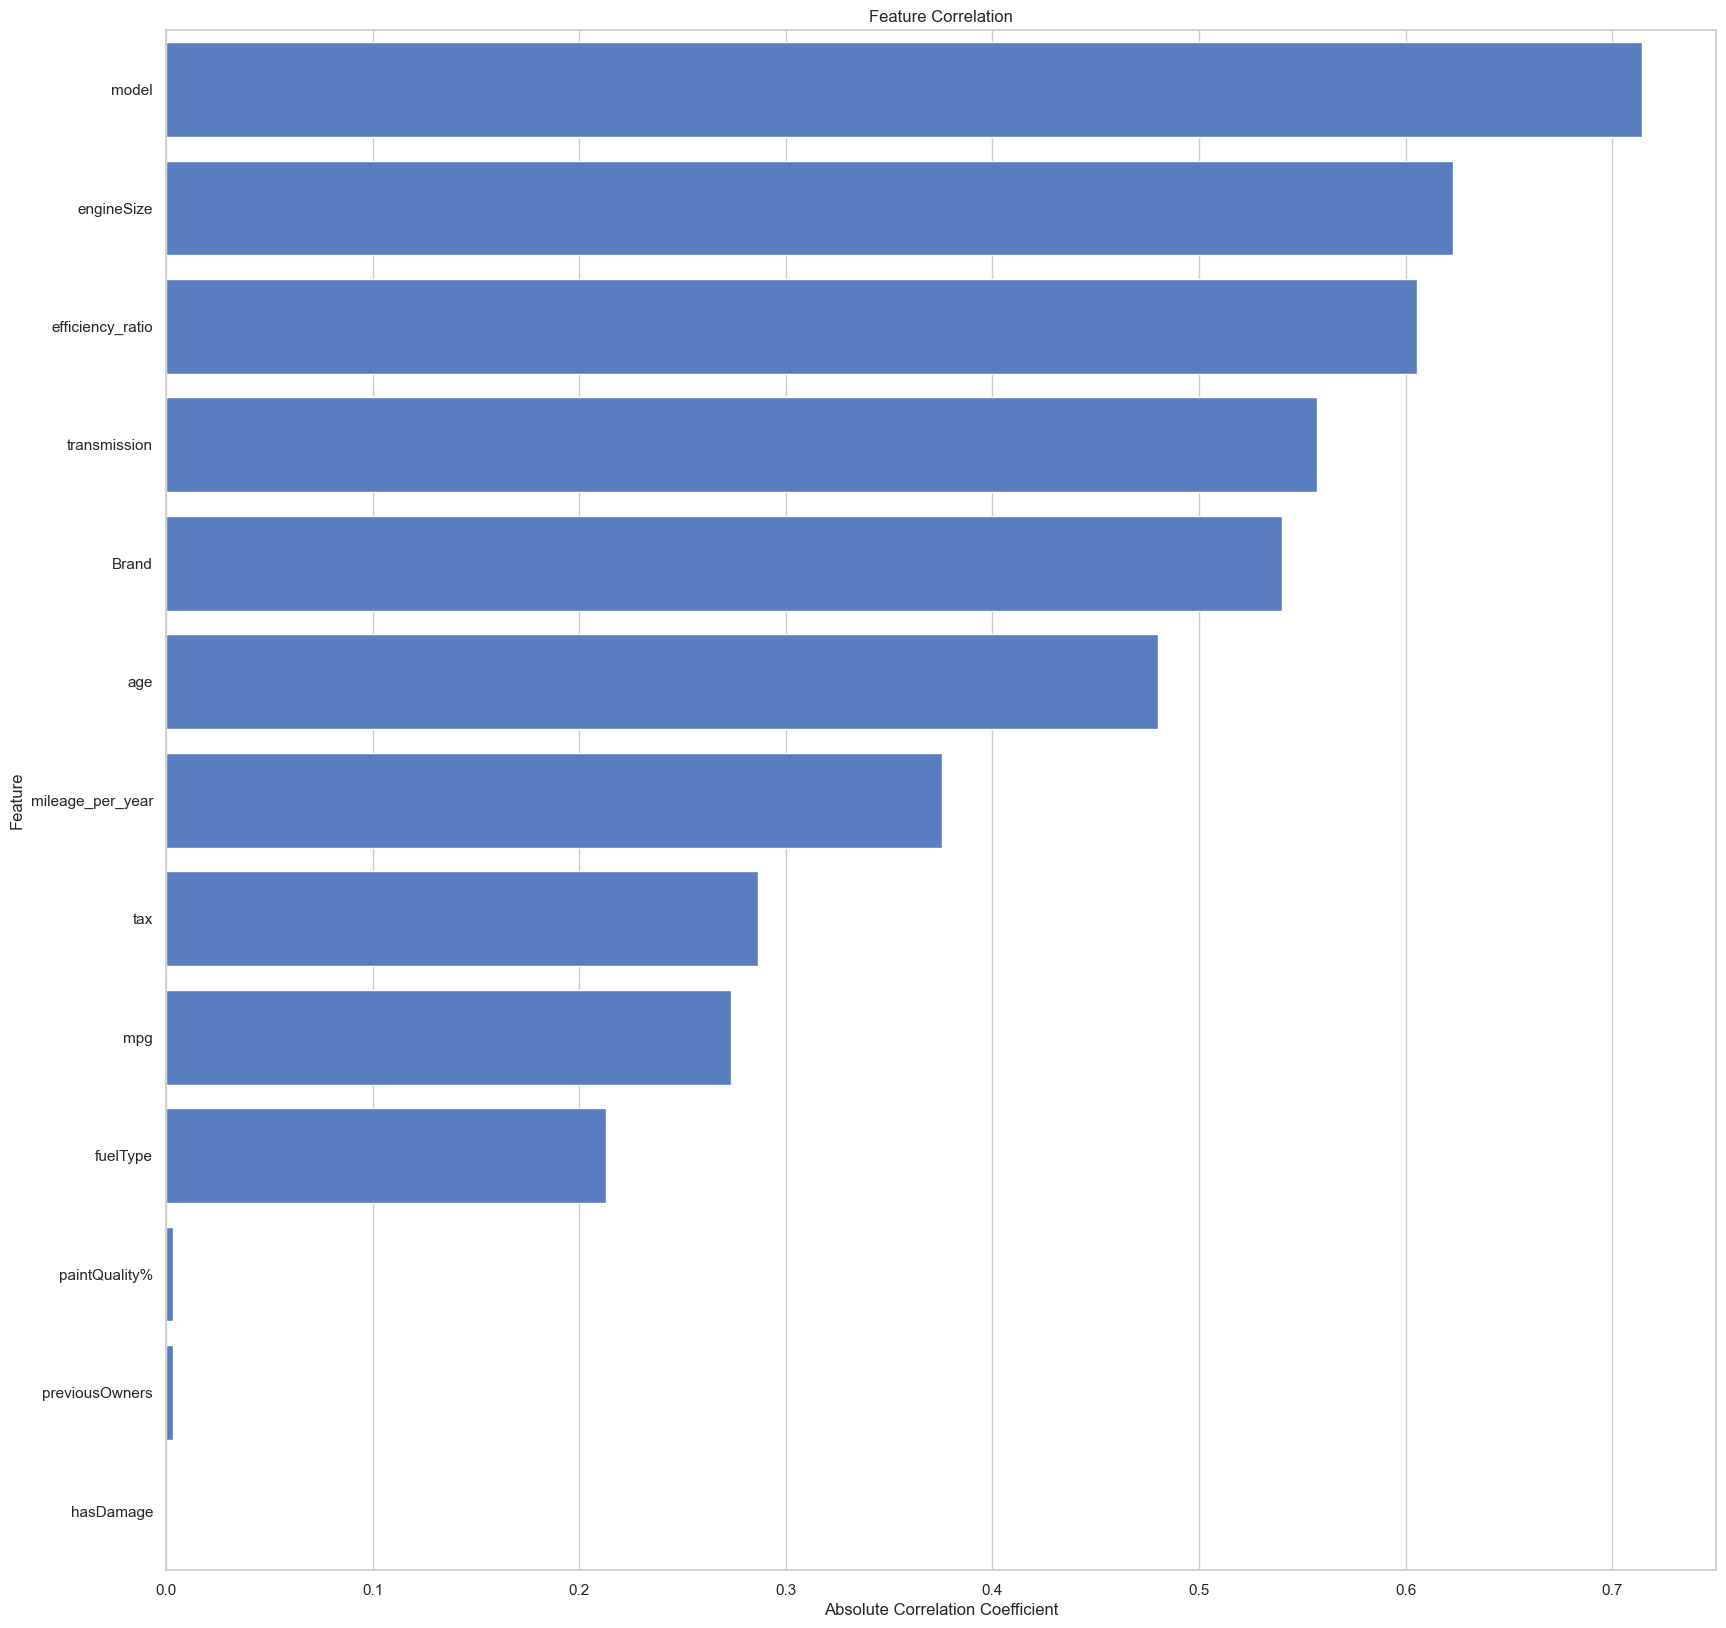

In [29]:
plt.figure(figsize=(20, 20))
sns.barplot(x=corr_scores, y=corr_scores.index)
plt.title("Feature Correlation")
plt.xlabel("Absolute Correlation Coefficient")
plt.ylabel("Feature")
plt.show()

In [30]:
top_features = corr_scores.index.tolist()
top_features.remove('hasDamage')
top_features.remove('previousOwners')
top_features.remove('paintQuality%')

X_train_n = X_train[top_features]
X_test_n  = X_test[top_features]


## Model Selection & Benchmarking

We evaluate a diverse set of regression algorithms to find the best predictor for car prices.

### 3.1 Model Optimization
* **Action:** Multiple RandomizedSearch experiments were performed for different regression models in order to tune their hyperparameters and identify configurations that achieved the best possible performance.
* **Reasoning:** Default model parameters are rarely optimal for a given dataset, especially when dealing with complex relationships and heterogeneous features. RandomizedSearch was chosen over exhaustive grid search because it allows exploration of a wide hyperparameter space more efficiently while keeping computational cost reasonable. By tuning each model individually, the comparison between models becomes fairer and reflects their true potential rather than their default behavior.
* **Evaluation:** Hyperparameter tuning consistently improved model performance compared to untuned versions. Ensemble-based models benefited the most from this process, showing noticeable reductions in test error and improved generalization. The tuned results provided a more reliable basis for model comparison and helped identify the most stable and accurate model for further analysis and deployment.

### 3.2 Candidate Models
We compare models ranging from simple baselines to complex ensembles:
1.  **Baseline:** `LinearRegression` (to establish a minimum performance benchmark).
2.  **Single Tree Model:** `DecisionTreeRegressor`
3.  **Tree Ensembles:** `RandomForest`, `ExtraTrees`, and `BaggingRegressor`.
4.  **Boosting:** `HistGradientBoostingRegressor`

### 3.3 Assessment Metrics

All models were evaluated using the **holdout method** (train–test split) to assess their ability to generalize to unseen data. Instead of relying on a single metric, multiple complementary evaluation measures were used to capture different aspects of model performance, including accuracy, robustness, and generalization.

The assessment metrics are defined as follows:

1. **Test Mean Absolute Error (MAE):**  
   Measures the average absolute difference between predicted and actual values on the test set. This metric serves as the primary measure of predictive accuracy, as it is directly interpretable in the original scale of the target variable.

2. **Root Mean Squared Error (RMSE):**  
   Computes the square root of the average squared prediction errors. RMSE penalizes larger errors more heavily than MAE and provides insight into the presence of extreme mispredictions.

3. **R² Score:**  
   Represents the proportion of variance in the target variable that is explained by the model. This metric helps evaluate how well the model captures the underlying structure of the data.

4. **Median Absolute Error (MedianAE):**  
   Calculates the median of absolute prediction errors, offering a robust measure of typical model performance that is less sensitive to outliers.

5. **Mean Absolute Percentage Error (MAPE):**  
   Expresses prediction error as a percentage of the true value, enabling scale-independent comparison and improving interpretability from a practical perspective.

6. **Composite Score (Generalization-Aware Metric):**  
   A custom metric designed to balance accuracy and generalization, defined as:  
   **Composite Score = Test MAE + 0.5 * max(0, Test MAE - Train MAE)**


    This metric prioritizes strong test performance while penalizing excessive overfitting.

Together, these metrics provide a balanced and reliable framework for comparing models, supporting a defensible and well-informed final model selection.


## Model Optimization

In [31]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.tree import DecisionTreeRegressor

# rf = DecisionTreeRegressor(random_state=42)

# grid = GridSearchCV(
#     rf,
#     param_grid=param_grid,
#     scoring="neg_mean_absolute_error",
#     cv=3,
#     n_jobs=-1,
#     return_train_score=True,  # important for diagnosis
#     verbose=2,
# )

# grid.fit(X_train_n, y_train_log)

# results = pd.DataFrame(grid.cv_results_)
# results = results.sort_values("mean_test_score", ascending=False)

# print(
#     results[
#         ["params", "mean_train_score", "mean_test_score", "std_test_score"]
#     ].head(10)
# )


In [32]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.ensemble import RandomForestRegressor

# param_grid = {
#     'n_estimators': [200,300, 400, 800, 900, ],
#     'max_depth': [10, 12, 15, 17, 20, 23, 25,],
#     'min_samples_leaf': [1, 2, 5, 8, 10, 13, 15],
#     'min_samples_split': [2, 4, 5, 7, 10, ]
# }

# rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# rf_search = RandomizedSearchCV(
#     rf,
#     param_grid,
#     n_iter=100,
#     scoring='neg_mean_absolute_error',
#     cv=5,
#     n_jobs=-1,
#     verbose=2,
#     return_train_score=True
# )

# rf_search.fit(X_train_n, y_train_log)

# best_model = rf_search.best_estimator_
# print(rf_search.best_params_)

In [33]:
# from sklearn.ensemble import ExtraTreesRegressor
# from sklearn.model_selection import RandomizedSearchCV

# # Define model
# etr = ExtraTreesRegressor(random_state=42, n_jobs=-1)

# # Parameter space
# param_dist = {
#     "n_estimators": [300, 500, 700, 900, 1100],
#     "max_depth": [10, 15, 20, 23, 25, None],
#     "min_samples_split": [2, 5, 8, 12, 20],
#     "min_samples_leaf": [1, 2, 3, 5, 8, 12],
#     "max_features": ["sqrt", "log2", 0.7, 0.5],
#     "bootstrap": [False],
# }

# # Random Search
# etr_search = RandomizedSearchCV(
#     estimator=etr,
#     param_distributions=param_dist,
#     n_iter=100,
#     scoring="neg_mean_absolute_error",
#     cv=5,
#     verbose=2,
#     random_state=42,
#     n_jobs=-1,
#     return_train_score=True
# )

# etr_search.fit(X_train_n, y_train_log)

# print("\nBest Parameters:", etr_search.best_params_)
# print("Best CV MAE:", -etr_search.best_score_)

In [34]:
# from itertools import product
# from sklearn.metrics import mean_absolute_error
# from sklearn.ensemble import ExtraTreesRegressor

# param_grid = {
#     "max_features": [0.5, 0.6, 0.7, 0.8],
#     "max_depth": [20, 23, 25, 27, 30],
#     "bootstrap": [True, False],
#     "min_samples_split": [2, 5, 7, 9, 10],
#     "min_samples_leaf": [1, 3, 5, 7, 9],
# }

# all_combinations = list(product(
#     param_grid["max_features"],
#     param_grid["max_depth"],
#     param_grid["bootstrap"],
#     param_grid["min_samples_split"],
#     param_grid["min_samples_leaf"]
# ))

# print(f"Total Models to Train: {len(all_combinations)}\n")

# results = []


# for (max_features, max_depth, bootstrap, min_samples_split, min_samples_leaf) in all_combinations:

#     model = ExtraTreesRegressor(
#         n_estimators=800,
#         max_features=max_features,
#         max_depth=max_depth,
#         bootstrap=bootstrap,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         n_jobs=-1,
#         random_state=42
#     )

#     model.fit(X_train_n, y_train_log)

#     train_pred = np.expm1(model.predict(X_train_n))
#     test_pred  = np.expm1(model.predict(X_test_n))

#     mae_train = mean_absolute_error(y_train, train_pred)
#     mae_test  = mean_absolute_error(y_test, test_pred)

#     result = {
#         "max_features": max_features,
#         "max_depth": max_depth,
#         "bootstrap": bootstrap,
#         "min_samples_split": min_samples_split,
#         "min_samples_leaf": min_samples_leaf,
#         "Train MAE": mae_train,
#         "Test MAE": mae_test,
#         "Gap": mae_test - mae_train
#     }
#     print("\n=========================================================================================")
#     display(result)
#     results.append(result)

# results_df = pd.DataFrame(results).sort_values("Test MAE", ascending=True)
# print("\n===== MODEL COMPARISON (BEST TEST MAE FIRST) =====")
# display(results_df)


In [35]:
# search_bag = RandomizedSearchCV(
#     estimator=BaggingRegressor(
#         estimator=DecisionTreeRegressor(random_state=42),
#         n_jobs=-1,
#         random_state=42
#     ),
#     param_distributions={
#         "n_estimators": [200, 500, 1000, 2000, 3200],
#         "max_samples": uniform(0.3, 0.7),
#         "max_features": uniform(0.3, 0.7),
#         "bootstrap": [True, False],
#         "bootstrap_features": [True, False],

#         "estimator__max_depth": [None, 10, 20, 30, 40],
#         "estimator__min_samples_split": randint(2, 30),
#         "estimator__min_samples_leaf": randint(1, 30),
#     },
#     n_iter=120,
#     scoring="neg_mean_absolute_error",
#     cv=5,
#     n_jobs=-1,
#     random_state=42,
#     verbose=1
# )

# search_bag.fit(X_train_n, y_train_log)
# best_bag = search_bag.best_estimator_

# best_hgb = hgb_search.best_estimator_

# y_train_pred_log = best_hgb.predict(X_train_n)
# y_test_pred_log  = best_hgb.predict(X_test_n)

# y_train_pred = np.expm1(y_train_pred_log)
# y_test_pred  = np.expm1(y_test_pred_log)

# train_mae = mean_absolute_error(y_train, y_train_pred)
# test_mae  = mean_absolute_error(y_test, y_test_pred)

# print("Best HGB Params:", hgb_search.best_params_)
# print(f"Train MAE: {train_mae:.2f}")
# print(f"Test  MAE: {test_mae:.2f}")
# print(f"Gap: {test_mae - train_mae:.2f}")



In [36]:
# from sklearn.ensemble import HistGradientBoostingRegressor
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint, uniform

# hgb = HistGradientBoostingRegressor(
#     loss="squared_error",   # MAE-optimized
#     random_state=42
# )

# param_distributions = {
#     "max_depth": [
#         None, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 16, 18, 20
#     ],

#     "max_leaf_nodes": [
#         8, 16, 24, 32, 48, 64, 96, 128, 160, 192, 224, 256,
#         320, 384, 448, 512
#     ],

#     "min_samples_leaf": [
#         1, 2, 5, 10, 15, 20, 30, 40, 50, 75, 100, 150, 200
#     ],

#     "learning_rate": [
#         0.005, 0.01, 0.015, 0.02, 0.03, 0.05,
#         0.075, 0.1, 0.15, 0.2, 0.25, 0.3
#     ],

#     "max_iter": [
#         100, 200, 300, 400, 600, 800,
#         1000, 1200, 1500, 1800, 2200, 3000
#     ],

#     "l2_regularization": [
#         0.0, 1e-4, 1e-3, 1e-2,
#         0.05, 0.1, 0.25, 0.5,
#         1.0, 2.0, 5.0, 10.0
#     ],

#     "max_bins": [
#         32, 48, 64, 80, 96, 128, 160, 192, 224, 255
#     ],

#     "early_stopping": [True],
#     "validation_fraction": [
#         0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3
#     ],

#     "tol": [
#         1e-8, 1e-7, 1e-6, 1e-5, 1e-4
#     ],

#     "random_state": [42],
# }



# hgb_search = RandomizedSearchCV(
#     estimator=hgb,
#     param_distributions=param_distributions,
#     n_iter=1000,
#     scoring="neg_mean_absolute_error",
#     cv=5,
#     n_jobs=-1,
#     verbose=2,
#     random_state=42,
#     return_train_score=True
# )

# hgb_search.fit(X_train_n, y_train_log)


## Model Training and Evaluation

In [37]:
models = {
    "LinearRegression": LinearRegression(),

    "DecisionTreeRegressor": DecisionTreeRegressor(
        max_depth=20,
        min_samples_split=9,
        min_samples_leaf=12,
        random_state=42 
    ),

    "RandomForestRegressor": RandomForestRegressor(
        n_estimators=3200,
        min_samples_split=5,
        min_samples_leaf=7,
        max_depth=25,
        max_samples=0.5,
        max_features=0.8,
        n_jobs=-1,
        random_state=42
    ),

    "ExtraTreesRegressor": ExtraTreesRegressor(
        n_estimators=3200,
        min_samples_split=4,
        min_samples_leaf=3,
        max_depth=30,
        max_features=0.5,
        n_jobs=-1,
        bootstrap=True,
        random_state=42
    ),
    "BaggingRegressor": BaggingRegressor(
        estimator=DecisionTreeRegressor(
            max_depth=35,
            min_samples_leaf=9,
            min_samples_split=12,
            random_state=42
        ),
        n_estimators=3200,
        max_samples=0.5,
        max_features=0.8,
        bootstrap=False,
        bootstrap_features=False,
        n_jobs=-1,
        random_state=42
    ),
    "HistGradientBoostingRegressor": HistGradientBoostingRegressor(
        **{
            'l2_regularization': np.float64(0.8083973481164611),
            'learning_rate': np.float64(0.07092275383467414),
            'max_depth': 14,
            'max_iter': 1197,
            'max_leaf_nodes': 103,
            'min_samples_leaf': 32
        }
    ),
}

results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_n, y_train_log)

    # Predictions in log space
    y_train_pred_log = model.predict(X_train_n)
    y_test_pred_log  = model.predict(X_test_n)

    # Back to original target space
    y_train_pred = np.expm1(y_train_pred_log)
    y_test_pred  = np.expm1(y_test_pred_log)

    # MAE in original scale
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test  = mean_absolute_error(y_test,  y_test_pred)

    print(f"{name} - Train MAE: {mae_train:.2f} | Test MAE: {mae_test:.2f}")

    results.append({
        "Model": name,
        "Train MAE": mae_train,
        "Test MAE": mae_test,
        "Gap (Test - Train)": mae_test - mae_train,
    })

# Comparison table
results_df = pd.DataFrame(results).sort_values("Test MAE")
print("\n\nMODEL COMPARISON (sorted by Test MAE)")
display(results_df)


Training LinearRegression...
LinearRegression - Train MAE: 2330.14 | Test MAE: 2328.02

Training DecisionTreeRegressor...
DecisionTreeRegressor - Train MAE: 1344.87 | Test MAE: 1619.12

Training RandomForestRegressor...
RandomForestRegressor - Train MAE: 1290.48 | Test MAE: 1460.91

Training ExtraTreesRegressor...
ExtraTreesRegressor - Train MAE: 1193.16 | Test MAE: 1403.26

Training BaggingRegressor...
BaggingRegressor - Train MAE: 1286.18 | Test MAE: 1445.16

Training HistGradientBoostingRegressor...
HistGradientBoostingRegressor - Train MAE: 1141.30 | Test MAE: 1311.26


MODEL COMPARISON (sorted by Test MAE)


,Model,Train MAE,Test MAE,Gap (Test - Train)
5,HistGradientBoostingRegressor,1141.303628,1311.263968,169.960340
3,ExtraTreesRegressor,1193.156391,1403.264400,210.108009
4,BaggingRegressor,1286.177060,1445.159995,158.982935
2,RandomForestRegressor,1290.482138,1460.911674,170.429536
1,DecisionTreeRegressor,1344.868201,1619.124661,274.256460
0,LinearRegression,2330.143316,2328.022821,-2.120495


# Model Evaluation Metrics — Explanation & Justification

To justify the selection of the final model, we evaluated all candidate models using multiple complementary performance metrics. Each metric captures a different aspect of model behavior, ensuring that the selected model is not only accurate but also stable and well-generalized.

---

## Mean Absolute Error (MAE)

**Definition**  
Mean Absolute Error measures the average absolute difference between the predicted and actual target values.

**What it measures**
- Overall prediction accuracy
- Average magnitude of errors in the original target units

**Why it matters**
- Directly interpretable (e.g., average price error)
- Less sensitive to outliers than squared-error metrics

**Interpretation**
- Lower MAE indicates better predictive performance
- Used as the **primary optimization metric**

---

## Root Mean Squared Error (RMSE)

**Definition**  
Root Mean Squared Error is the square root of the average of squared prediction errors.

**What it measures**
- Sensitivity to large prediction errors
- Penalizes extreme mistakes more heavily than MAE

**Why it matters**
- Important in pricing tasks where large errors are costly
- Complements MAE by capturing error variance

**Interpretation**
- RMSE ≥ MAE (always)
- A large gap between RMSE and MAE indicates the presence of outliers

---

## R² Score (Coefficient of Determination)

**Definition**  
R² measures the proportion of variance in the target variable explained by the model.


**What it measures**
- Goodness of fit
- Explanatory power of the model

**Why it matters**
- Intuitive for non-technical stakeholders
- Shows how well the model captures overall price variation

**Interpretation**
- \( R^2 = 1 \): perfect fit  
- \( R^2 = 0 \): no better than predicting the mean  
- Higher values indicate better explanatory performance

---

## Median Absolute Error (Median AE)

**Definition**  
Median Absolute Error is the median of absolute prediction errors.

**What it measures**
- Typical prediction error
- Robustness to extreme outliers

**Why it matters**
- Reflects the error most users are likely to experience
- Useful when the error distribution is skewed

**Interpretation**
- Median AE < MAE suggests some large outliers exist
- Close Median AE and MAE indicates stable predictions

---

## Mean Absolute Percentage Error (MAPE)

**Definition**  
MAPE measures the average percentage difference between predictions and actual values.

**What it measures**
- Relative prediction accuracy in percentage terms

**Why it matters**
- Scale-independent
- Easy to interpret for business contexts

**Caveat**
- Sensitive to very small or zero target values

**Interpretation**
- Lower MAPE indicates better relative accuracy
- Used as a supplementary metric

---


## Composite Generalization Score

**Definition**  
A combined score that balances predictive accuracy and generalization.

Where \( \lambda \) is a penalty weight (here, \( \lambda = 0.5 \)).

**What it measures**
- Overall model quality with overfitting penalty

**Why it matters**
- Prevents selecting models that overfit despite low test error
- Encourages stable generalization

**Interpretation**
- Lower score is better
- Used for final model ranking

---

## Final Evaluation Strategy

- **Primary metric:** MAE  
- **Error severity:** RMSE  
- **Explained variance:** R²  
- **Robustness:** Median Absolute Error  
- **Generalization:** Overfitting Ratio  
- **Final ranking:** Composite Score  

This multi-metric evaluation ensures that the selected model is accurate, stable, and generalizes well to unseen data.


In [38]:
metrics = []

for name, model in models.items():
    y_train_pred = np.expm1(model.predict(X_train_n))
    y_test_pred  = np.expm1(model.predict(X_test_n))

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae  = mean_absolute_error(y_test, y_test_pred)

    metrics.append({
        "Model": name,
        "MAE": test_mae,
        "RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred)),
        "R2": r2_score(y_test, y_test_pred),
        "MedianAE": median_absolute_error(y_test, y_test_pred),
        "MAPE (%)": np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100,
        "Composite Score": test_mae + 0.5 * max(0, test_mae - train_mae),
    })

metrics_df = pd.DataFrame(metrics).sort_values("Composite Score")
display(metrics_df)


,Model,MAE,RMSE,R2,MedianAE,MAPE (%),Composite Score
5,HistGradientBoostingRegressor,1311.263968,2298.215331,0.942891,825.945853,7.944882,1396.244139
3,ExtraTreesRegressor,1403.264400,2615.654673,0.926026,859.813207,8.551401,1508.318405
4,BaggingRegressor,1445.159995,2713.351532,0.920397,875.488159,8.808895,1524.651462
2,RandomForestRegressor,1460.911674,2735.175302,0.919111,875.192985,8.850412,1546.126442
1,DecisionTreeRegressor,1619.124661,2916.955273,0.908002,982.685885,9.874550,1756.252891
0,LinearRegression,2328.022821,3880.737717,0.837165,1538.066477,14.337150,2328.022821


## ✅ Final Model Selection

Based on  
1. **Lowest Test MAE** (overall accuracy),  
2. **Lowest RMSE** (control over large errors),  
3. **Highest R² score** (maximum explained variance),  
4. **Lowest Median Absolute Error and MAPE** (stable and robust predictions), and  
5. **Lowest Composite Score with a controlled Overfitting Ratio** (balanced generalization),  

we select **HistGradientBoostingRegressor** as the final model.


## Open-Ended Section

### Objectives and Approach

The objective of this section was to gain additional insights beyond simply improving model accuracy by adding new techniques. Instead, the focus was on understanding how different modeling choices affect performance, stability, and generalization. The aim was to evaluate whether certain decisions in the modeling process were actually beneficial and to identify a model that would perform reliably in a real-world setting.

The main objectives were to compare different types of regression models under the same preprocessing pipeline, evaluate models using multiple performance metrics rather than a single score, and assess the impact of preprocessing decisions such as outlier handling.

---

### Actions Taken

Several comparative experiments were carried out to meet these objectives. Different regression models from multiple model families were trained using the same preprocessing steps to ensure a fair comparison. The target variable was transformed during training and converted back to its original scale during evaluation so that results remained interpretable.

Model performance was evaluated using a range of metrics to capture accuracy, robustness, and generalization. In addition, outlier handling was tested and later removed after observing that it negatively affected model performance. This comparison was done while keeping the rest of the pipeline unchanged. The preprocessing and prediction steps were also tested for both batch predictions and single data entries to ensure consistency and suitability for deployment.

---

### Results and Key Findings

The results showed clear differences between model families. Simpler linear models were unable to capture the complexity of the data and consistently underperformed. Ensemble-based models performed better overall, but their stability and generalization varied.

Among all evaluated models, the gradient boosting approach consistently achieved the best balance between accuracy and generalization across all metrics. It produced the lowest prediction errors while maintaining a reasonable gap between training and test performance.

Outlier handling was found to worsen performance. Removing extreme values reduced the model’s ability to learn from legitimate data points and led to poorer generalization.

---

### Final Takeaways

This open-ended analysis showed that better insights can be obtained by comparing modeling strategies and design decisions rather than simply adding new techniques. Evaluating multiple metrics, comparing different model families, and questioning common preprocessing assumptions led to a more reliable and well-generalizing model. The final model was selected based on balanced performance and robustness, making it suitable for practical use.


## End-to-End Inference Pipeline (Deployment)

To ensure reproducibility and eliminate the risk of manual errors, we encapsulate our entire processing workflow into a single function: `run_test_pipeline`.

### Objective
This function takes a raw dataset (e.g., `test.csv`) and produces final price predictions by applying the exact same transformations used during training.

### Key Principles
1.  **Consistency:** Every step (cleaning, text normalization, feature engineering) is applied in the exact same order as the training pipeline.
2.  **Leakage Prevention:** Crucially, this function strictly uses **pre-fitted artifacts** (the trained `imputer`, `scaler`, `target_encoder`, and `model`) passed as arguments. It performs **no learning (fitting)** on the test data—it only applies (transforms) the patterns learned from the training set.
3.  **Target Transformation:** It automatically handles the reverse transformation (`np.expm1`), converting the model's log-scale predictions back into the original currency (pounds).

### Pipeline Steps
1.  **Load & Clean:** Import raw data and fix inconsistent numerical formats.
2.  **Imputation:** Apply the hierarchical mappings and median statistics derived from training.
3.  **Feature Engineering:** Generate `age`, `efficiency_ratio`, etc.
4.  **Encoding & Scaling:** Apply the trained Target Encoder and Standard Scaler.
5.  **Prediction:** Generate final values and export to CSV.

In [39]:
def run_test_pipeline(
    test_csv_path,
    model,
    substring_maps,
    rare_maps,
    num_imputer,
    hierarchical_maps,
    cat_imputer,
    cat_cols,
    te,
    scaler,
    num_cols_new,
    top_features,
    output_path="submission9.csv"
):
    test_df = pd.read_csv(test_csv_path)
    num_cols_raw = test_df.select_dtypes(include=[np.number]).columns.drop("carID")
    test_df = apply_numerical_data_cleaning(test_df, num_cols_raw)
    test_df = preprocess_text_test(
        test_df,
        substring_maps=substring_maps,
        rare_maps=rare_maps
    )
    test_df = preprocess_test(
        X_test=test_df,
        num_cols=num_cols_raw,
        num_imputer=num_imputer,
        hierarchical_maps=hierarchical_maps,
        cat_imputer=cat_imputer,
        cat_cols=cat_cols
    )
    cat_cols_te = test_df.select_dtypes(exclude=["number"]).columns.tolist()

    X_test_te = te.transform(test_df[cat_cols_te])
    X_test_te = pd.DataFrame(
        X_test_te,
        columns=cat_cols_te,
        index=test_df.index
    )

    test_df = pd.concat(
        [test_df.drop(columns=cat_cols_te), X_test_te],
        axis=1
    )


    for col in test_df.columns:
        if col in test_df.columns:
            remaining = test_df[col].isna().sum()
            print(f"Test Data -- {col}: {remaining}")


    missing = test_df[num_cols_raw].isna().sum().sort_values(ascending=False)
    print("Missing values in Test numeric columns after imputation:\n")
    display(missing.to_frame("Missing Train Count"))
    test_df = add_features(test_df)
    test_df = drop_highly_correlated_features(test_df)
    test_df[num_cols_new] = scaler.transform(test_df[num_cols_new])
    y_pred_log = model.predict(test_df[top_features])
    y_pred = np.expm1(y_pred_log)
    id_col = "carID" if "carID" in test_df.columns else "car_ID"

    submission = pd.DataFrame({
        id_col: test_df[id_col].astype(int),
        "price": y_pred
    })

    submission.to_csv(output_path, index=False)
    return submission




submission = run_test_pipeline(
    test_csv_path="project_data/test.csv",
    model=models.get('HistGradientBoostingRegressor'),
    substring_maps=substring_maps,
    rare_maps=rare_maps,
    num_imputer=num_imputer,
    hierarchical_maps=hierarchical_maps,
    cat_imputer=cat_imputer,
    cat_cols=cat_cols,
    te=te,
    scaler=scaler,
    num_cols_new=num_cols_new,
    top_features=top_features,
    output_path="submission12.csv"
)

submission.head()



Test Data -- carID: 0
Test Data -- year: 0
Test Data -- mileage: 0
Test Data -- tax: 0
Test Data -- mpg: 0
Test Data -- engineSize: 0
Test Data -- paintQuality%: 0
Test Data -- previousOwners: 0
Test Data -- hasDamage: 0
Test Data -- Brand: 0
Test Data -- model: 0
Test Data -- transmission: 0
Test Data -- fuelType: 0
Missing values in Test numeric columns after imputation:



,Missing Train Count
year,0
mileage,0
tax,0
mpg,0
engineSize,0
paintQuality%,0
previousOwners,0
hasDamage,0


,carID,price
0,89856,10574.419530
1,106581,25073.049843
2,80886,13704.341811
3,100174,17820.026254
4,81376,22599.108589


## Car Price Estimation Module (Real-World Usage)

This module is designed to **estimate the market value of a car in real-world scenarios**, using the same logic, transformations, and assumptions that were applied during model training. The key idea is **consistency** — the model should see new data exactly the way it saw historical data.

### How a Real-World Price Estimate Is Generated
When a new car is passed into the module, the following steps happen internally:

1. **Input alignment**
   - Raw car details (brand, year, mileage, etc.) are converted into a structured format
   - Column names are normalized to match training data
2. **Schema enforcement**
   - All required numerical fields are ensured to exist
   - Missing values are safely handled
3. **Data cleaning**
   - Numerical inconsistencies are fixed
   - Text values are normalized and standardized
4. **Missing value handling**
   - Same imputers used during training are applied
5. **Categorical encoding**
   - Target encoding transforms categories into meaningful numeric signals
6. **Feature engineering**
   - Additional real-world indicators (e.g. age, efficiency ratios) are created
   - Redundant features are removed
7. **Scaling**
   - Numerical features are scaled using the trained scaler
8. **Price prediction**
   - Model predicts in log space
   - Prediction is converted back to the actual market price

---

### Outcome
This module acts as a **plug-and-play car valuation engine**.  
Give it a car’s details, and it returns an estimated price that reflects real-world market behavior — powered by a fully reproducible machine learning pipeline.


In [40]:
artifacts = {
    "model": models.get("HistGradientBoostingRegressor"),
    "substring_maps": substring_maps,
    "rare_maps": rare_maps,
    "num_imputer": num_imputer,
    "hierarchical_maps": hierarchical_maps,
    "cat_imputer": cat_imputer,
    "cat_cols": cat_cols,
    "te": te,
    "scaler": scaler,
    "num_cols_new": num_cols_new,
    "top_features": top_features,
}

joblib.dump(artifacts, "price_model_artifacts1.joblib")


['price_model_artifacts1.joblib']

In [41]:
artifacts = joblib.load("price_model_artifacts.joblib")

model = artifacts["model"]
substring_maps = artifacts["substring_maps"]
rare_maps = artifacts["rare_maps"]
num_imputer = artifacts["num_imputer"]
hierarchical_maps = artifacts["hierarchical_maps"]
cat_imputer = artifacts["cat_imputer"]
cat_cols = artifacts["cat_cols"]
te = artifacts["te"]
scaler = artifacts["scaler"]
num_cols_new = artifacts["num_cols_new"]
top_features = artifacts["top_features"]

def align_features(df, feature_list):
    return df.reindex(columns=feature_list, fill_value=0)

def predict_single_entry(
    input_dict,
    model,
    substring_maps,
    rare_maps,
    num_imputer,
    hierarchical_maps,
    cat_imputer,
    cat_cols,
    te,
    scaler,
    num_cols_new,
    top_features
):
    test_df = pd.DataFrame([input_dict])

    if 'brand' in test_df.columns:
        test_df.rename(columns={'brand': 'Brand'}, inplace=True)

    raw_num_cols = [
        'year', 'mileage', 'tax', 'mpg', 'engineSize', 
        'paintQuality%', 'previousOwners', 'hasDamage'
    ]

    for col in raw_num_cols:
        if col not in test_df.columns:
            test_df[col] = 0
            
    test_df = apply_numerical_data_cleaning(test_df, raw_num_cols)
    
    test_df = preprocess_text_test(
        test_df,
        substring_maps=substring_maps,
        rare_maps=rare_maps
    )
    
    test_df = preprocess_test(
        X_test=test_df,
        num_cols=raw_num_cols, 
        num_imputer=num_imputer,
        hierarchical_maps=hierarchical_maps,
        cat_imputer=cat_imputer,
        cat_cols=cat_cols
    )
    
    cat_cols_te = test_df.select_dtypes(exclude=["number"]).columns.tolist()
    if cat_cols_te:
        X_test_te = te.transform(test_df[cat_cols_te])
        X_test_te = pd.DataFrame(
            X_test_te,
            columns=cat_cols_te,
            index=test_df.index
        )
        test_df = pd.concat([test_df.drop(columns=cat_cols_te), X_test_te], axis=1)

    test_df = add_features(test_df)
    test_df = drop_highly_correlated_features(test_df)
    
    test_df[num_cols_new] = scaler.transform(test_df[num_cols_new])
    
    y_pred_log = model.predict(test_df[top_features])
    y_pred = np.expm1(y_pred_log)
    
    return y_pred[0]


sample_input = {
    "carID": 12345,
    "brand": "Toyota",
    "model": "Corolla",
    "year": 2018,
    "mileage": 45000,
    "engineSize": 1.6,
    "fuelType": "petrol",
    "transmission": "manual",
    "tax": 150,
    "mpg": 45.0,
    "hasDamage": 1,
    "paintQuality%": 100,
    "previousOwners": 1
}

price = predict_single_entry(
    input_dict=sample_input,
    model=model,
    substring_maps=substring_maps,
    rare_maps=rare_maps,
    num_imputer=num_imputer,
    hierarchical_maps=hierarchical_maps,
    cat_imputer=cat_imputer,
    cat_cols=cat_cols,
    te=te,
    scaler=scaler,
    num_cols_new=num_cols_new,
    top_features=top_features
)

print(f"Predicted price: {price:.2f}")

Predicted price: 14873.56


/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator _BinMapper from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator HistGradientBoostingRegressor from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.6.1 when using version 1.7.2. This might lea